## Import neccesary packages

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
import cartopy.crs as ccrs

# Optional, hide warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

## Select network to edit

In [2]:
n = pypsa.Network("results/networks/elec.nc")

INFO:pypsa.io:Imported network elec_s_6_ec_lcopt_Co2L-24H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Visualization

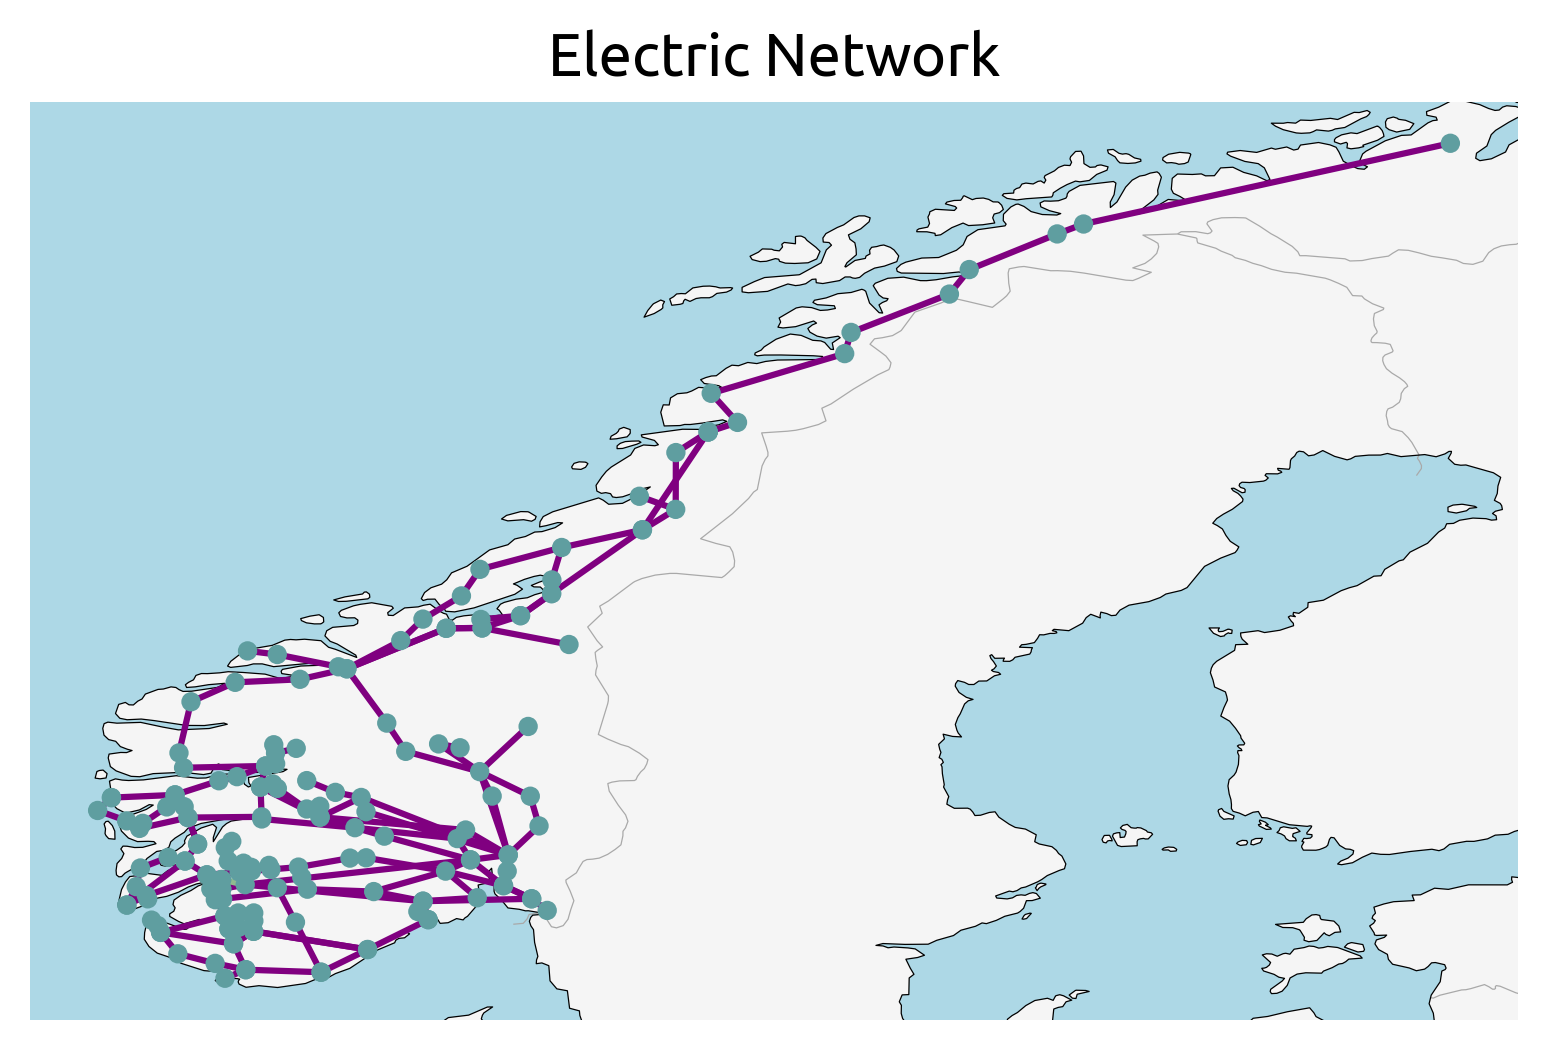

In [4]:

n.plot(color_geomap=True, title="Electric Network", line_colors="purple");

# Components

In [4]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Components '{}' has {} entries".format(c.name,len(c.df)))

Components 'Bus' has 170 entries
Components 'Carrier' has 15 entries
Components 'Line' has 180 entries
Components 'LineType' has 34 entries
Components 'Transformer' has 32 entries
Components 'TransformerType' has 14 entries
Components 'Link' has 2 entries
Components 'Load' has 55 entries
Components 'Generator' has 167 entries
Components 'StorageUnit' has 344 entries


# Add demand from chargers to network

## Add artifical charging availability to time series

array([<AxesSubplot:>], dtype=object)

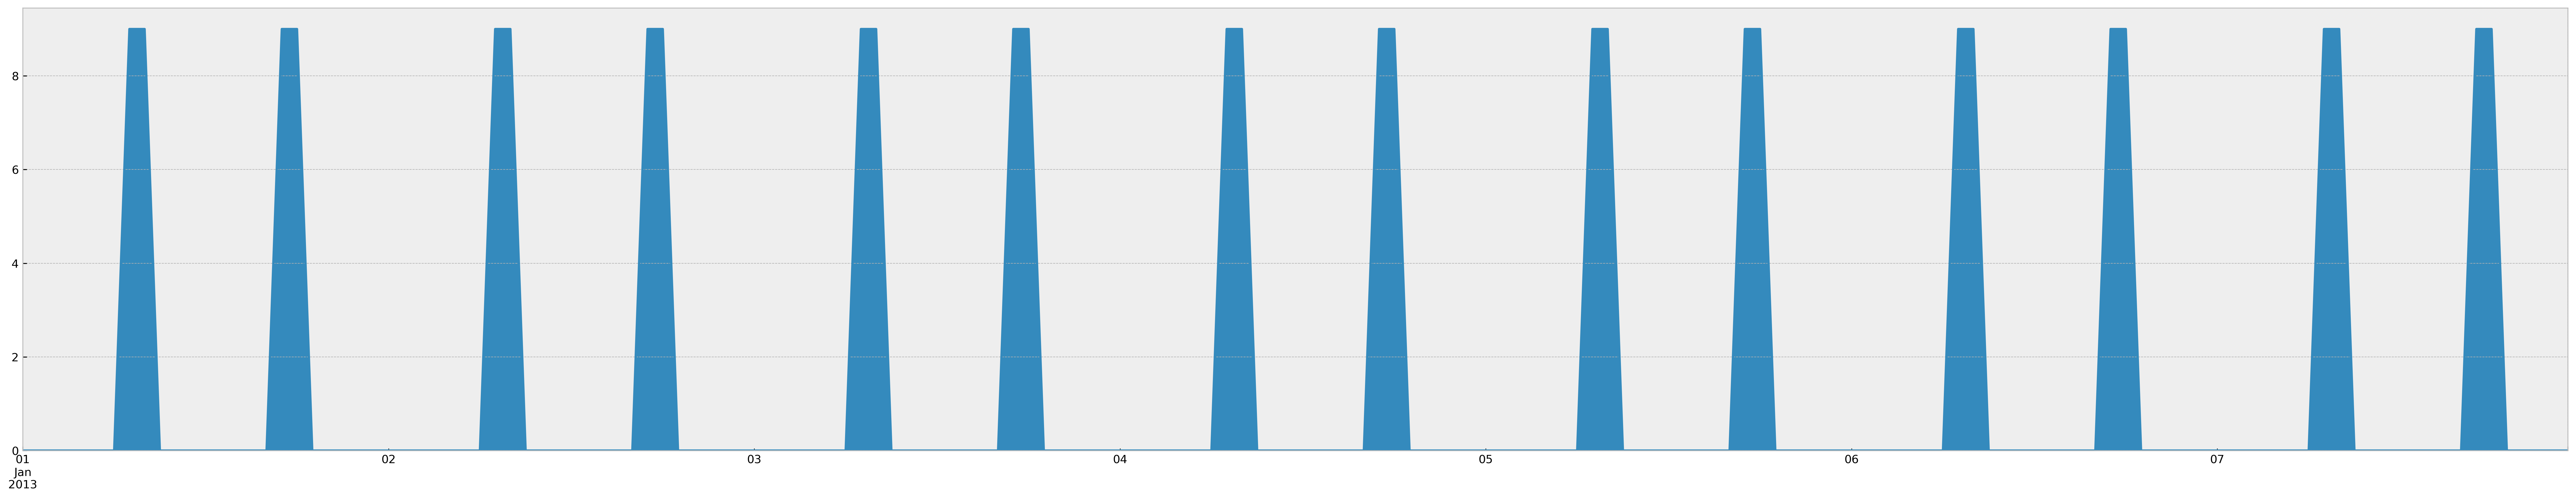

In [4]:

# use 24 hour period for consideration
index_24h = pd.date_range("2013-01-01 00:00", "2013-01-01 23:00", freq="H")
index_1y = pd.date_range("2013-01-01 00:00", "2013-12-31 23:00", freq="H")
index_1w = pd.date_range("2013-01-01 00:00", "2013-01-07 23:00", freq="H")

# consumption pattern of BEV
day_usage = [0.0] * 7 + [9.0] * 2 + [0.0] * 8 + [9.0] * 2 + [0.0] * 5
# Create time series for 2013 to implement in PyPSA-eur
bev_usage_1y = pd.Series(day_usage * (365), index_1y)

# Optional - for plotting
bev_usage_1d = pd.Series(day_usage, index_24h)
bev_usage_1w = pd.Series(day_usage * 7, index_1w)

bev_usage_1w.plot.area(subplots=True, figsize=(40, 7))


In [11]:
tot_chargers = pd.read_csv("tot_chargers.csv")
tot_cap = tot_chargers["capacity"].sum()/1000 #MW
print("Total capacity of " + str(len(tot_chargers)) + " chargers in MW: ", tot_cap)

Total capacity of 26559 chargers in MW:  1389.5112000000001


In [9]:
evs_norway = 599169 # Total number of EVs (personal cars)
avg_battery_size = 60/1000 # MWh - avg size of battery
tot_battery_size = evs_norway * avg_battery_size
print("Total battery capacity in MW: ", tot_battery_size)

Total battery capacity in MW:  35950.14


## Read optimal cs locations

In [12]:
new_cs = pd.read_csv("tot_chargers.csv")
new_cs_index = new_cs.index.tolist()
new_cs_x = new_cs["x"].tolist()
new_cs_y = new_cs["y"].tolist()
new_cs_cap = new_cs["capacity"].tolist()
new_cs_geometry = []
for l in range(0, len(new_cs_index)):
    new_cs_geometry.append((new_cs_x[l], new_cs_y[l]))

## Read installed buses from network

In [13]:
bus_list = pd.DataFrame()
bus_list
bus_list_index = n.buses.index.tolist()
bus_list_x = n.buses["x"].tolist()
bus_list_y = n.buses["y"].tolist()
ex_bus_loc = []
for coordinate in range(0, len(bus_list_index)):
    ex_bus_loc.append((bus_list_x[coordinate], bus_list_y[coordinate]))
bus_list_index

NameError: name 'n' is not defined

## Define function for calculating the shortest distance between buses

In [6]:
from scipy import spatial

def calc_distance(iterator):
    tree = spatial.KDTree(ex_bus_loc)
    distance, name_of_bus = tree.query(new_cs_geometry[iterator])
    return name_of_bus

## Make DataFrame object of closest_bus_id and position of charger (x,y)

In [7]:
#calc_distance(0)
nearest_bus_id = []
for cs in new_cs_index:
    nearest_bus_id.append(calc_distance(cs))
nearest_bus_id
nearest_bus = [bus_list_index[i] for i in nearest_bus_id]
data = {"Bus":nearest_bus, "x":new_cs_x, "y":new_cs_y, "capacity":new_cs_cap}
df_bus_cs = pd.DataFrame(data)
df_bus_cs

,Bus,x,y,capacity
0,6365,7.54816,58.010380,7.4
1,6365,7.54816,58.010380,7.4
2,6365,7.54816,58.010380,7.4
3,6365,7.54816,58.010380,7.4
4,6362,7.04675,57.982498,3.6
...,...,...,...,...
26554,7017,23.48247,69.973282,250.0
26555,7017,23.48247,69.973282,250.0
26556,7017,23.48247,69.973282,250.0
26557,7017,23.48247,69.973282,250.0


## Create function for adding CS bus, Line and Load

In [8]:
def add_charger(nr, long, lat, closest_bus, capacity):
    charger_name = "fast_charger_" + str(nr)
    battery_name = "battery_" + str(nr)
    
    n.add("Bus", battery_name, carrier="DC", x = long, y=lat)
    n.add("Store", "battery_storage_"+str(nr), bus=battery_name, e_cyclic=True, e_nom=468/1000) #468kWh
    #n.add("Bus", charger_name, carrier="AC", x = long, y = lat)
    
    #n.add("Bus", "battery", carrier="Li-ion")

    n.add("Load", "driving"+str(nr), bus=battery_name, p_set=bev_usage_1y)

    n.add(
        "Link",
        charger_name,
        bus0=closest_bus,
        bus1=battery_name,
        p_nom=capacity/1000,  # Capacity of charger #MW
        #p_max_pu=charger_p_max_pu,      In future implement p_max_pu for charger
        efficiency=0.9,
    )


## Finally, calculate and add CS to network

In [9]:
# Use the function add_charger for every charger in tot_charger.csv
for i in range(0,len(df_bus_cs["x"])):
    add_charger(i, df_bus_cs["x"][i], df_bus_cs["y"][i], df_bus_cs["Bus"][i], df_bus_cs["capacity"][i])
n.plot

<bound method plot of PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 26729
 - Carrier: 15
 - Generator: 167
 - Line: 180
 - Link: 26561
 - Load: 26614
 - StorageUnit: 344
 - Store: 26559
 - Transformer: 32
Snapshots: 8760>

In [ ]:
# Export the network, and replace with exsisting elec.nc file in resources/networks/
n.export_to_netcdf("elec.nc");

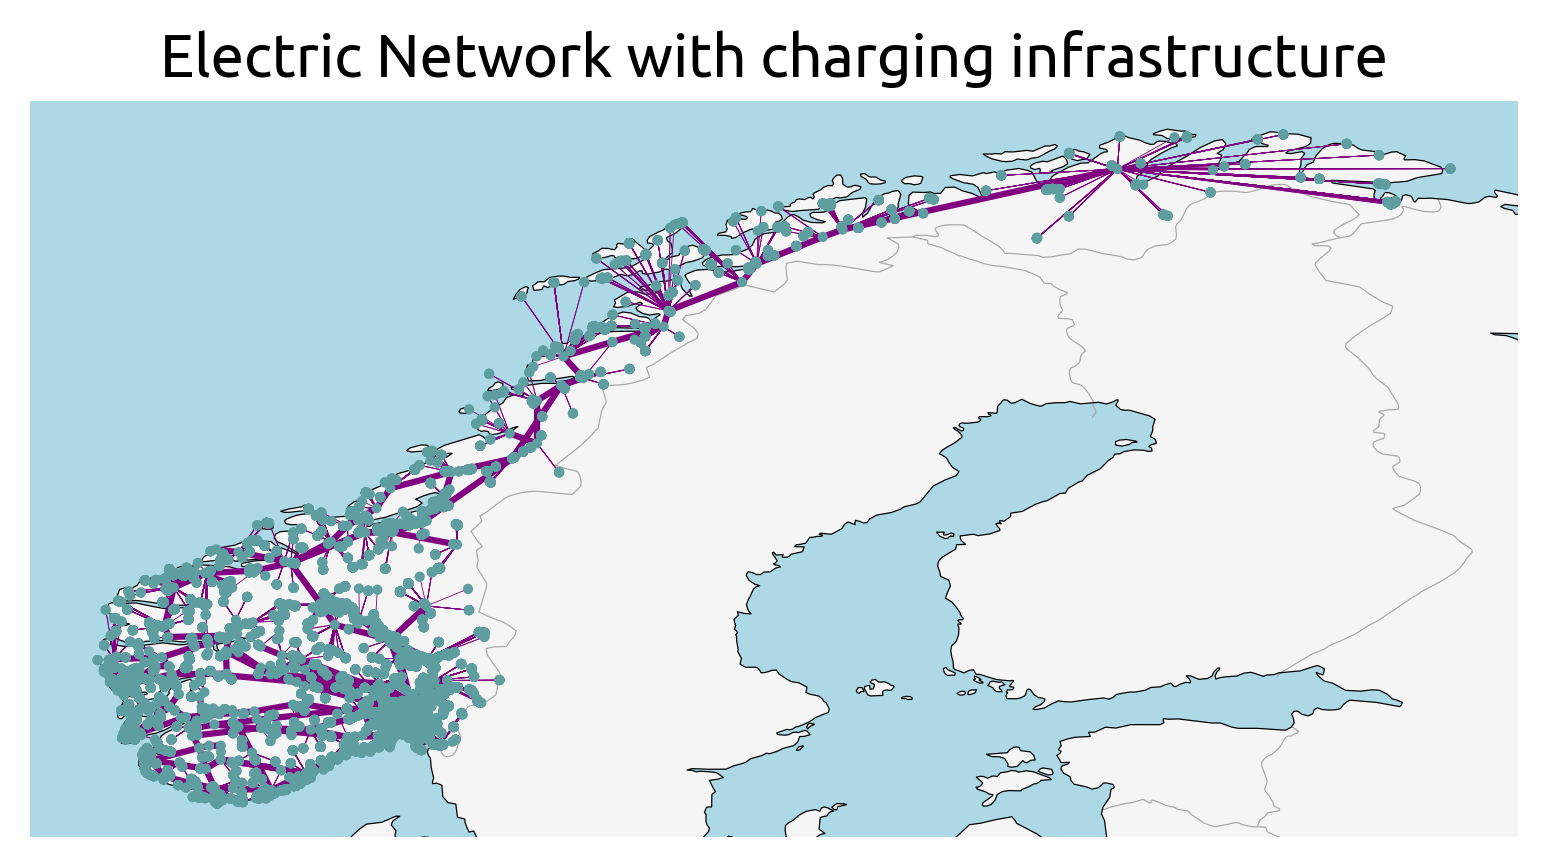

In [17]:
n.plot(color_geomap=True, title="Electric Network with charging infrastructure", line_colors="purple", link_colors="purple", bus_sizes=1/1e2, link_widths=0.2);